<a href="https://colab.research.google.com/github/safreitas2000/ml-analytics-mvp/blob/main/machine-learning/ML_MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning
## Aluno   : Sérgio Augusto Freitas Filho
DataSet : Salary Prediction Classification (https://www.kaggle.com/datasets/ayessa/salary-prediction-classification)
**Descrição do problema:** Prever com base nos atributos do dataset se determinada pessoa fatura mais ou menos que 50k por ano.
O dataset selecionado apresenta características de cada indivíduo, entre elas, cor da pele, sexo, escolaridade, nacionalidade, ocupação, entre outras. O objetivo é com base nessas características determinar entre 2 faixas de renda anual, denominado Target >50k ou <=50K.
Para selecionar os dados, por questões didáticas optamos pela simplificidade e escolhemos um problema de classificação com variável predita categórica em 2 classes >50k e <=50K.

In [22]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada
from sklearn.feature_selection import RFE # para a Eliminação Recursiva de Atributos
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Carga do Dataset
Realizada 2 ações de pré-processamento:
1. Exclui as linhas com dados faltantes, marcados com "?" no dataset
2. Uso da classe sklearn.preprocessing.LabelEncoder para codificar os atributos object (texto) em valores numéricos entre 0 e n_classes-1.

In [23]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/safreitas2000/ml-analytics-mvp/main/salary.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Seleciona apenas as colunas que são variáveis categóricas
categorical_columns = dataset.select_dtypes(include=['object']).columns

# Cria uma instância do OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Aplica o OneHotEncoder nas colunas categóricas e retorna um novo DataFrame com as colunas codificadas
encoded_columns = encoder.fit_transform(dataset[categorical_columns])

# Obtém os nomes das colunas codificadas a partir dos rótulos únicos das categorias originais
encoded_column_names = encoder.get_feature_names_out(categorical_columns)

# Cria um novo DataFrame com as colunas codificadas
dataset_encoded = pd.DataFrame(encoded_columns, columns=encoded_column_names)

# Concatena as colunas codificadas com o DataFrame original
dataset_encoded = pd.concat([dataset.drop(columns=categorical_columns), dataset_encoded], axis=1)

#eliminei a coluna duplicada do target que não é necessária.
dataset_encoded = dataset_encoded.drop(columns=['salary_ >50K'])

#Utiliza o LabelEncoder como rotina de pré-processamento
#le = LabelEncoder()
#for column_name in dataset.columns:
#       if dataset[column_name].dtype == object:
#            dataset[column_name] = le.fit_transform(dataset[column_name])
#       else:
#            pass

# Mostra as primeiras linhas do dataset
dataset_encoded.head()
#display(dataset_encoded)

#dataset.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,salary_ <=50K
0,39,77516,13,2174,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,50,83311,13,0,0,13,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,38,215646,9,0,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,53,234721,7,0,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,28,338409,13,0,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Separação em conjunto de treino e conjunto de teste e uso da validação cruzada com 10 partições.
-> Separado 80% da base para treino e 20% para teste.
-> Utilizado método de **validação cruzada com 10 partições** para melhorar o processo de treinamento e confiança na estimativa de desempenho.
-> Utilizado **SelectKBest** para seleção dos melhores atributos para predição, foram realizados testes comparativos com diferentes valores para k, mostrou-se mais efetivo com 10 atributos e apresentou perda de confiança quando utilizado número reduzido de atributos.

In [31]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset_encoded.values
X = array[:,0:108]
y = array[:,108]

#SelectKBest#
# Seleção de atributos com SelectKBest
best_var = SelectKBest(score_func=f_classif, k=90)

# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
fit = best_var.fit(X, y)

# Reduz X para os atributos selecionados
features = fit.transform(X)

# Resultados
print('\nNúmero original de atributos:', X.shape[1])
print('\nNúmero reduzido de atributos:', features.shape[1])

# Exibe as pontuações de cada atributos e os 10 escolhidas (com as pontuações mais altas)
np.set_printoptions(precision=3) # 3 casas decimais
print("\nScores dos Atributos Originais:", fit.scores_)
print("\nAtributos Selecionados:", best_var.get_feature_names_out(input_features=dataset_encoded.columns[0:108]))

X_train, X_test, y_train, y_test = train_test_split(features, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação


Número original de atributos: 108

Número reduzido de atributos: 90

Scores dos Atributos Originais: [1.887e+03 2.916e+00 4.120e+03 1.709e+03 7.548e+02 1.813e+03 2.003e+02
 1.152e+02 3.569e+01 2.221e+00 2.020e+02 6.459e+02 2.937e+01 7.175e+00
 4.443e+00 1.605e+02 2.418e+02 6.516e+01 3.890e+01 6.852e+01 1.158e+02
 1.016e+02 3.440e-01 3.287e+00 1.096e+03 5.825e+02 5.702e+02 1.023e+03
 1.621e+01 8.005e+02 1.320e+02 5.337e+02 4.737e+00 8.026e+03 5.900e+01
 3.674e+03 1.812e+02 1.355e+02 2.023e+02 2.658e+02 8.283e-01 5.150e+00
 1.576e+03 8.802e+01 2.498e+02 1.576e+02 8.158e+02 4.493e+01 1.165e+03
 2.576e+01 1.828e+01 2.151e+01 1.502e+01 6.240e+03 1.199e+03 2.298e+02
 1.794e+03 6.783e+02 5.023e+02 2.688e+01 3.620e+00 2.605e+02 3.302e+01
 2.382e+02 1.593e+03 1.593e+03 3.004e-01 1.693e+00 4.413e+00 2.749e-01
 1.385e+01 2.603e-01 1.729e+01 1.471e+00 1.414e+01 4.226e+00 4.751e+00
 4.860e+00 1.951e-01 1.320e+01 5.416e+00 3.172e-01 1.911e+00 3.835e-01
 7.171e-03 1.391e+01 7.446e+00 1.386e-01 4.136

## Modelagem e Inferência
Selecionado algoritmos para problemas de classificação em aprendizado supervisionado, categórico com target em 2 classes possíveis. Salário >50k ou <=50K.
Algoritmos selecionados : Regressão Logística, KNN, Árvore de decisão, Naive Bayes, SVM e os ensambles BaggingClassifier, RandomForest, ExtraTrees, AdaBoost, GradientBoosting e Voting.
Os parâmetros da árvore de decisão num_trees e max_features foram variados e fixados em 100 e 3 que apresentou melhor resultado.

### Criação e avaliação de modelos: linha base

LR: 0.798181 (0.005057)
KNN: 0.771921 (0.005067)
CART: 0.815878 (0.007654)
NB: 0.796875 (0.006215)
SVM: 0.794802 (0.002536)
Bagging: 0.856495 (0.004861)
RF: 0.850353 (0.003300)
ET: 0.828739 (0.007564)
Ada: 0.863944 (0.003543)
GB: 0.865518 (0.005106)
Voting: 0.815878 (0.003069)


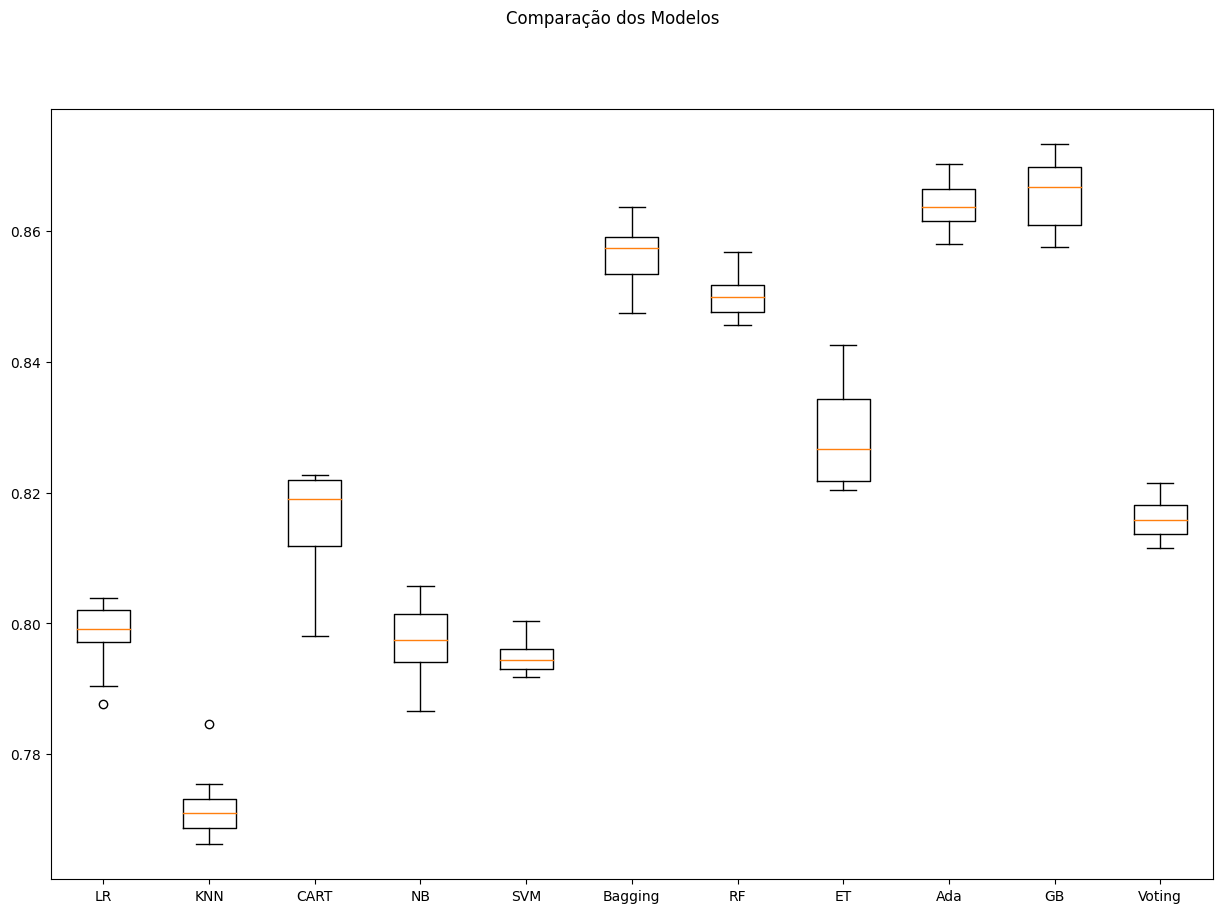

In [32]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados
-> Utilização de padronização e normalização no pipeline e comparação de performance entre os algoritmos de classificação escolhidos para análise da acurácia.
-> Não foi verificada a situação de underfitting
-> Os ensambles apresentaram os melhores resultados, em particular o Adaboost e o gradient_boosting.

LR-orig: 0.799 (0.010)
KNN-orig: 0.840 (0.009)
CART-orig: 0.820 (0.006)
NB-orig: 0.800 (0.007)
SVM-orig: 0.803 (0.006)
Bag-orig: 0.843 (0.008)
RF-orig: 0.846 (0.009)
ET-orig: 0.836 (0.007)
Ada-orig: 0.863 (0.005)
GB-orig: 0.864 (0.005)
Vot-orig: 0.817 (0.008)
LR-padr: 0.824 (0.008)
KNN-padr: 0.831 (0.007)
CART-padr: 0.819 (0.007)
NB-padr: 0.802 (0.006)
SVM-padr: 0.848 (0.005)
Bag-padr: 0.843 (0.010)
RF-padr: 0.844 (0.008)
ET-padr: 0.836 (0.008)
Ada-padr: 0.863 (0.005)
GB-padr: 0.864 (0.005)
Vot-padr: 0.846 (0.006)
LR-norm: 0.822 (0.008)
KNN-norm: 0.824 (0.008)
CART-norm: 0.819 (0.006)
NB-norm: 0.802 (0.006)
SVM-norm: 0.844 (0.005)
Bag-norm: 0.843 (0.008)
RF-norm: 0.846 (0.009)
ET-norm: 0.835 (0.008)
Ada-norm: 0.863 (0.005)
GB-norm: 0.864 (0.005)
Vot-norm: 0.844 (0.007)


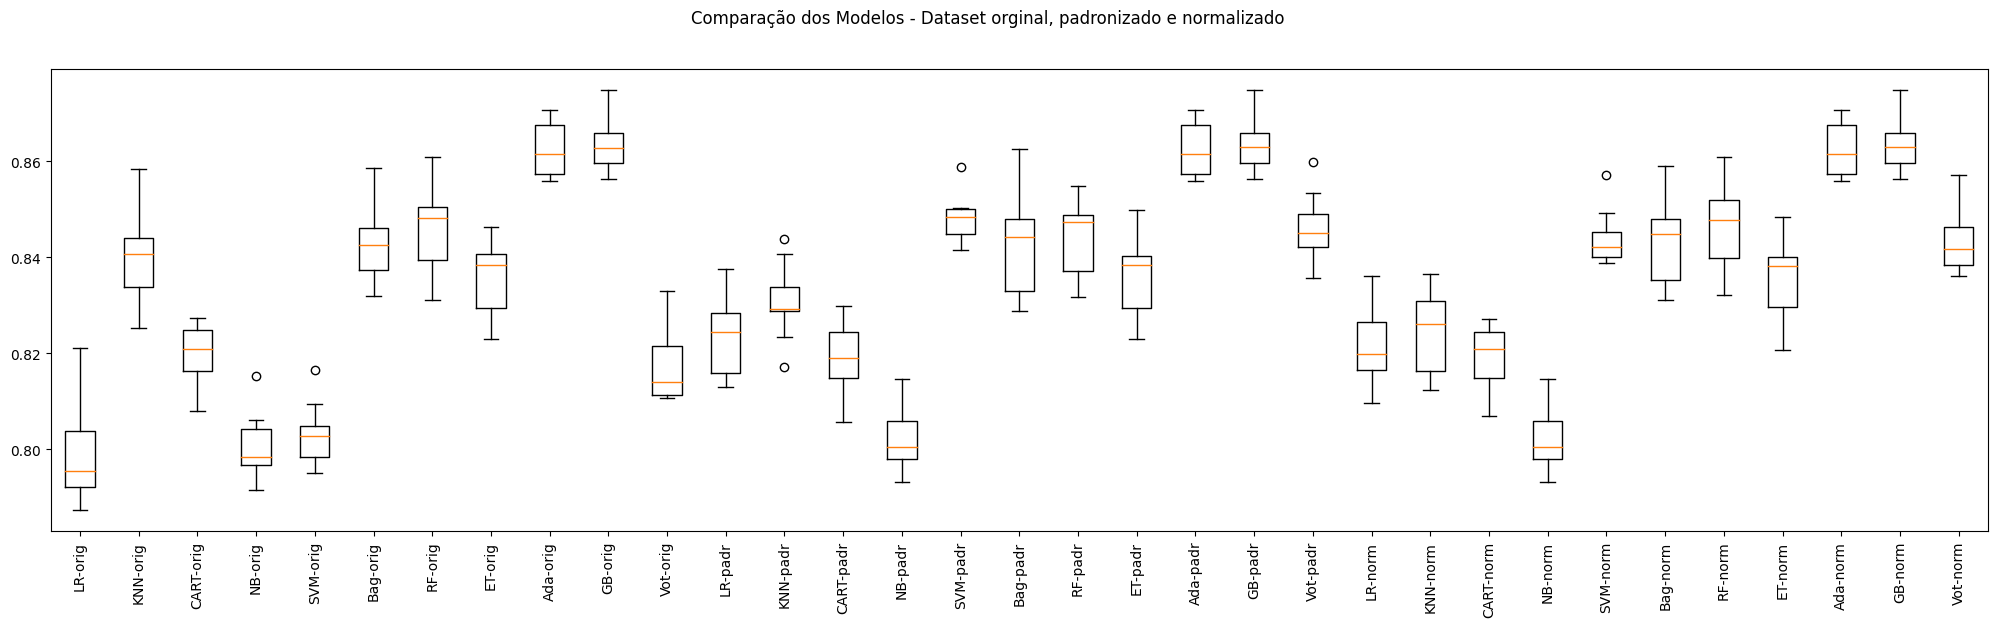

In [6]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros
1. Em análise dos valores de acurácia obtidos após aplicação da validação cruzada e confirmado após aplicação da normalização e padronização no pipeline,observei uma  melhor performance dos ensambles e resolvi testar a variação dos hiperparametros para o AdaBoost. O GridSearchCV apresentou como resposta Melhores hiperparâmetros: {'learning_rate': 1.0, 'n_estimators': 150}.



In [7]:
# Tuning do AdaBoost

np.random.seed(7) # definindo uma semente global para este bloco

# Definir os hiperparâmetros que deseja otimizar
parametros = {
    'n_estimators': [50, 100, 150],  # número de estimadores
    'learning_rate': [0.1, 0.5, 1.0]  # taxa de aprendizado
}

# Criar uma instância do AdaBoostClassifier
adaboost = AdaBoostClassifier()

# Criar uma instância do GridSearchCV
grid_search = GridSearchCV(adaboost, parametros, cv=5)

# Realizar a busca em grade (grid search) com validação cruzada
grid_search.fit(X_train, y_train)

# Visualizar os melhores hiperparâmetros encontrados
melhores_hiperparametros = grid_search.best_params_
print("Melhores hiperparâmetros:", melhores_hiperparametros)

Melhores hiperparâmetros: {'learning_rate': 1.0, 'n_estimators': 150}


## Finalização do Modelo e Avaliação de Resultados
-> Escolhi a métrica de acurácia, por ser adequada para o problema categórico em questão com 2 classes. Como é supervisionado e possuímos a base de treino e teste com o target real e os valores preditos , essa métrica é adequada para verificação da qualidade e performance do modelo na predição das classes, quanto maior a taxa de acerto melhor.
-> Nesta seção será treinado o modelo com a base de treino de forma segregada e posteriormente testado com a base de teste. Mantendo o isolamento entre os dados de treino e teste.

In [8]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
adaboost = AdaBoostClassifier(learning_rate=1.0,n_estimators=150)
adaboost.fit(X_train, y_train)

name = 'adaboost'

cv_results = cross_val_score(adaboost, X_train, y_train, cv=kfold, scoring=scoring)
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)


# Estimativa da acurácia no conjunto de teste
predictions = adaboost.predict(X_test)
print(accuracy_score(y_test, predictions))

adaboost: 0.864481 (0.006258)
0.863196683555965
